In [17]:
import cv2
from PIL import Image
from collections import defaultdict
import seaborn as sns
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
plt.style.use('ggplot')
%matplotlib inline


In [19]:
data_dir = "fruit_copy/"  
output_dir = "outputs/"
os.makedirs(output_dir, exist_ok=True)

In [20]:
classes = sorted(os.listdir(data_dir))
print(f"Total classes: {len(classes)}")
print(f"Class names: {classes}")

Total classes: 9
Class names: ['apple fruit', 'banana fruit', 'cherry fruit', 'chickoo fruit', 'grapes fruit', 'kiwi fruit', 'mango fruit', 'orange fruit', 'strawberry fruit']


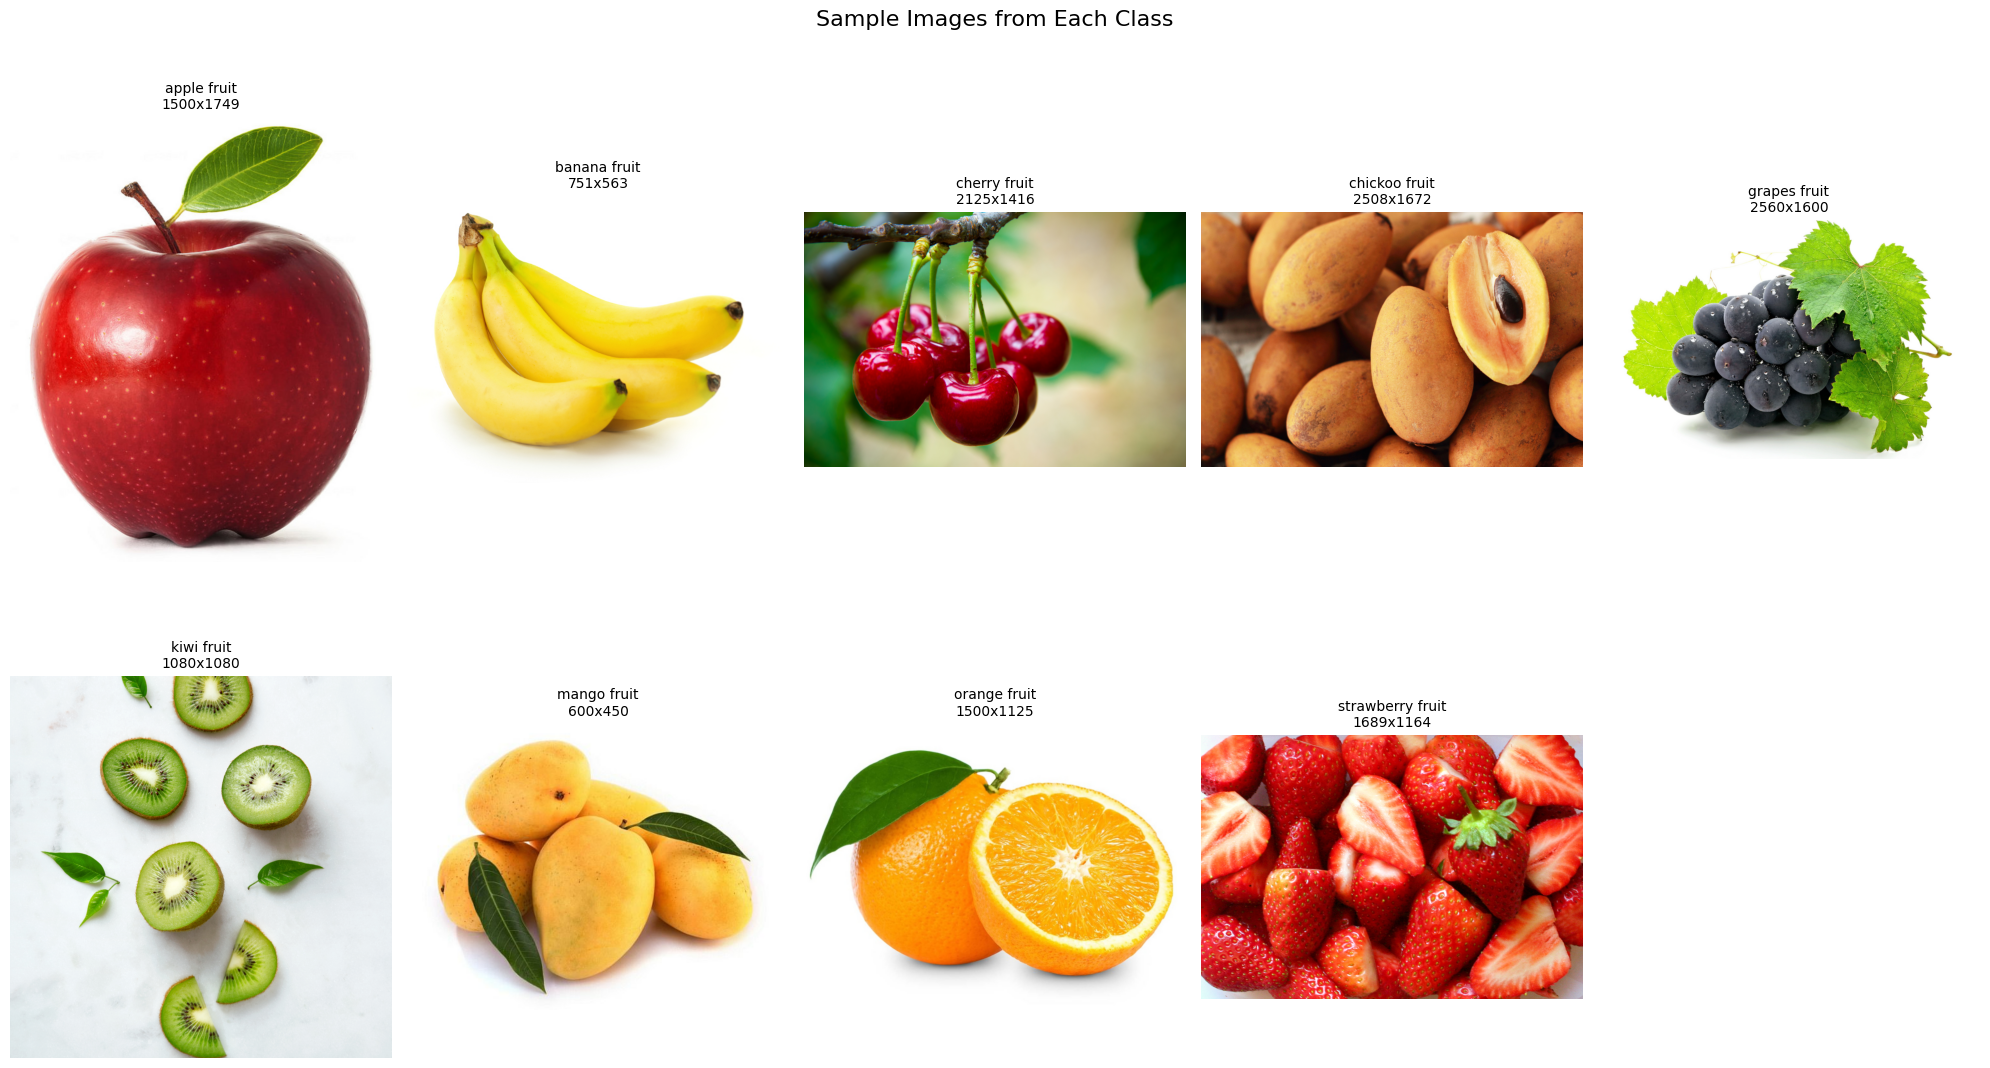

In [21]:
plt.figure(figsize=(20, 12))
for i, cls in enumerate(classes[:10]):  
    class_path = os.path.join(data_dir, cls)
    img_name = os.listdir(class_path)[0]  
    img_path = os.path.join(class_path, img_name)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{cls}\n{img.shape[1]}x{img.shape[0]}", fontsize=10)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "class_samples.png"))
plt.show()

In [22]:
dimensions = []
corrupted_files = []

# Resize images to 224x224 and save to output_dir
for cls in classes:
    class_input_path = os.path.join(data_dir, cls)
    class_output_path = os.path.join(output_dir, cls)
    os.makedirs(class_output_path, exist_ok=True)

    for img_name in os.listdir(class_input_path):
        img_input_path = os.path.join(class_input_path, img_name)
        img_output_path = os.path.join(class_output_path, img_name)

        try:
            with Image.open(img_input_path) as img:
                dimensions.append(img.size)  # store original dimensions
                img_resized = img.resize((224, 224))
                img_resized.save(img_output_path)
        except Exception as e:
            corrupted_files.append(img_input_path)

In [23]:
if corrupted_files:
    print(f"\n⚠️ Found {len(corrupted_files)} corrupted files:")
    for file in corrupted_files[:5]: 
        print(f"- {file}")
else:
    print("\n✅ No corrupted files found.")


⚠️ Found 2 corrupted files:
- fruit_copy/kiwi fruit\Image_35.jpg
- fruit_copy/orange fruit\Image_27.jpg


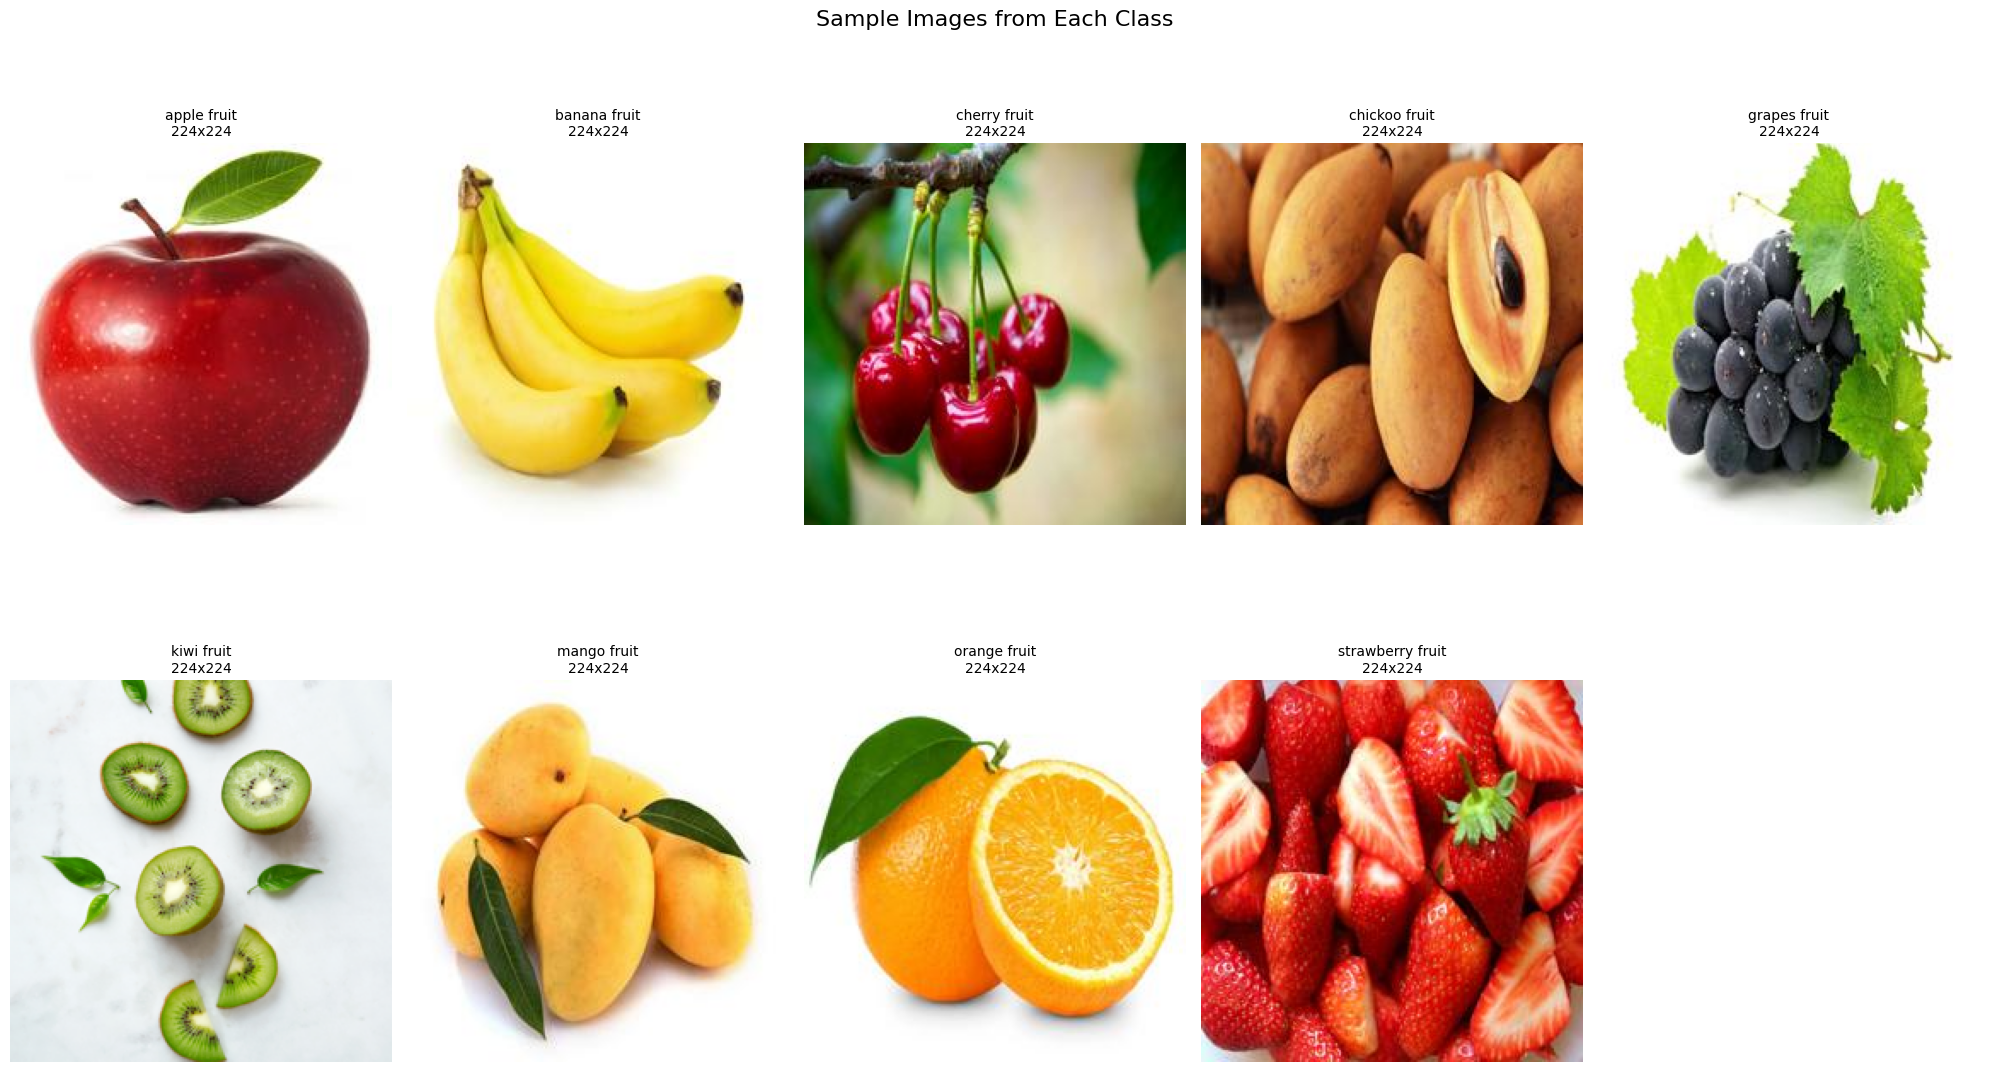

In [24]:
plt.figure(figsize=(20, 12))
for i, cls in enumerate(classes[:10]):  
    class_path = os.path.join(output_dir, cls)
    img_name = os.listdir(class_path)[0]  
    img_path = os.path.join(class_path, img_name)
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(f"{cls}\n{img.shape[1]}x{img.shape[0]}", fontsize=10)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

In [25]:

# DATASET PATH
dataset_path = "outputs/"

# PARAMETERS
batch_size = 32
img_height = 224
img_width = 224

# ImageDataGenerator data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,      # Rescale pixel values from [0, 255] to [0, 1], for better convergence
    validation_split=0.2    # Use 20% of data for validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    directory=dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

n_classes = len(list(train_generator.class_indices.keys()))

Found 288 images belonging to 9 classes.
Found 69 images belonging to 9 classes.


In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping

# Load InceptionV3 base model without the top layer (Only BackBone)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add new layers on top of the base model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x) 
x = layers.Dropout(0.5)(x)  # Add dropout for regularization
predictions = layers.Dense(n_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

In [27]:
# Fine-tuning strategy: unfreeze only the last few layers for fine-tuning
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [28]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=validation_generator, 
                    callbacks=[early_stopping])

c:\Users\muffi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.2193 - loss: 2.2344 - val_accuracy: 0.6812 - val_loss: 1.1609
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7352 - loss: 1.1939 - val_accuracy: 0.8986 - val_loss: 0.6038
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7925 - loss: 0.7457 - val_accuracy: 0.8696 - val_loss: 0.4416
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8907 - loss: 0.5375 - val_accuracy: 0.8551 - val_loss: 0.3680
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9275 - loss: 0.3729 - val_accuracy: 0.8841 - val_loss: 0.3039
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9492 - loss: 0.2992 - val_accuracy: 0.9275 - val_loss: 0.2610
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9746 - loss: 0.2115 - val_accuracy: 0.9420 - val_loss: 0.2373
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.9880 - loss: 0.1401 - val_accuracy: 0.9275 - val_loss: 0.2125
Epoch 9/

In [ ]:
def get_class_label(one_hot_encoded_label):
    class_index = np.argmax(one_hot_encoded_label)
    class_label = list(train_generator.class_indices.keys())[class_index]
    return class_label

In [30]:
# Retrieve a batch of images and labels
batch_imgs, batch_labels = next(train_generator)
batch_predictions = model.predict(batch_imgs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


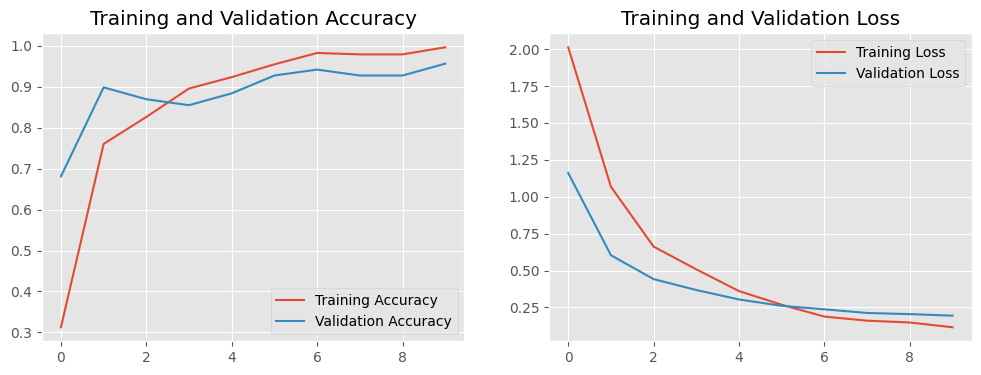

In [31]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

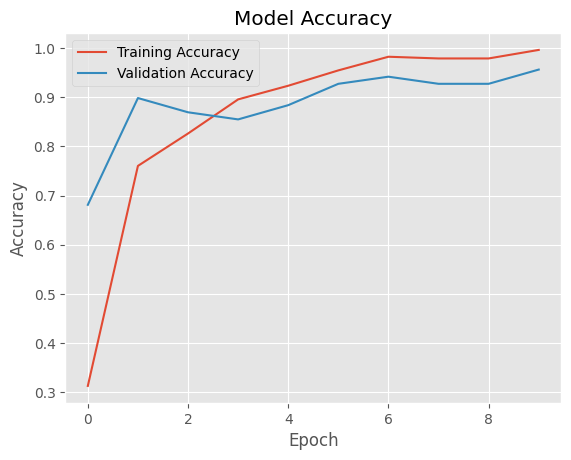

Model accuracy: 96.0 %


In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
print("Model accuracy:", round(history.history['val_accuracy'][-1], 2)*100,"%")

In [33]:
# import pickle
# with open("models/2.pkl", "wb") as f:
#     pickle.dump(model, f)

# print("✅ Model saved successfully as Pickle!")